In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install azureml

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install azureml.opendatasets

In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import _datetime
import json
import seaborn as sns
import dateutil.parser as dp

from azureml.opendatasets import PublicHolidays

from datetime import datetime
from json import dumps
from dateutil import parser
from dateutil.relativedelta import relativedelta

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from scipy.optimize import curve_fit

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets

#historical Holiday data
end_date = datetime.now()
print(end_date)
start_date = datetime.now() - relativedelta(months=60)
#hol = PublicHolidays(start_date=start_date, end_date=end_date)
#hol_df = hol.to_pandas_dataframe()

#historical Bitcoin data

#define a function to convert datetime data into custom string formatted data to pass to the strptime method
def myconverter(o):
    if isinstance(o, datetime):
        return "{}-{}-{}".format(o.year, o.month, o.day)

#convert the string formated date into YYYY-MM-DD format to pass to the URL
end_date_1 = _datetime.datetime.strptime(myconverter(end_date), '%Y-%m-%d').date()
print(end_date_1)
start_date_1 = _datetime.datetime.strptime(myconverter(start_date), '%Y-%m-%d').date()
print(start_date_1)
df = pd.read_json(f'https://api.coindesk.com/v1/bpi/historical/close/USD.json?start={start_date_1}&end={end_date_1}')
df.index.freq = 'D'

unix_start = datetime.timestamp(start_date)
print("timestamp =", unix_start)
unix_end = datetime.timestamp(end_date)
print("timestamp =", unix_end)
url = f'https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from={unix_start}&to={unix_end}'
dfe = pd.read_csv(url)
dfe = pd.DataFrame.from_dict(dfe, orient='index')

2021-04-08 09:02:01.395295
2021-04-08
2016-04-08
timestamp = 1460131321.395295
timestamp = 1617897721.395295


In [8]:
dfe

,"{""prices"":[[1460160000000",9.899719595415823],[1460246400000,8.814617175830122],[1460332800000,8.66829211893249],[1460419200000,7.51681223420342],[1460505600000,8.015604593105122],...,[1617494400000.2,34872897876.651085],[1617580800000.2,26817722961.480415],[1617667200000.2,30867393925.630993],[1617753600000.2,33391498272.783157],[1617840000000.2,39604003543.54452]]}


In [9]:
dfe_1 = pd.DataFrame(list(dfe.items()))
dfe_1 = dfe_1.rename(columns={0: "date", 1 : "todrop"})
dfe_1.head()
#dfe.head()

,date,todrop
0,"{""prices"":[[1460160000000","Series([], Name: {""prices"":[[1460160000000, dt..."
1,9.899719595415823],"Series([], Name: 9.899719595415823], dtype: ob..."
2,[1460246400000,"Series([], Name: [1460246400000, dtype: object)"
3,8.814617175830122],"Series([], Name: 8.814617175830122], dtype: ob..."
4,[1460332800000,"Series([], Name: [1460332800000, dtype: object)"


In [10]:
dfe_1 = dfe_1.drop(columns=['todrop'])
dfe_1.head()

,date
0,"{""prices"":[[1460160000000"
1,9.899719595415823]
2,[1460246400000
3,8.814617175830122]
4,[1460332800000


In [11]:
pd.set_option('display.max_rows', None)
dfe_1['date'].head()

0    {"prices":[[1460160000000
1           9.899719595415823]
2               [1460246400000
3           8.814617175830122]
4               [1460332800000
Name: date, dtype: object

In [12]:
dfe_1_price = dfe_1.iloc[:3653]
dfe_1_price = dfe_1_price.reset_index(drop=True)
dfe_1_mktcp = dfe_1.iloc[3653:7302]
dfe_1_mktcp = dfe_1_mktcp.reset_index(drop=True)
dfe_1_totvol = dfe_1.iloc[7302:]
dfe_1_totvol = dfe_1_totvol.reset_index(drop=True)
dfe_1_price.head()

,date
0,"{""prices"":[[1460160000000"
1,9.899719595415823]
2,[1460246400000
3,8.814617175830122]
4,[1460332800000


In [13]:
def column_parser(df):  
    epi = []
    epi = df[1::2]
    return epi;

def date_parser(df):
    date_df = []
    date_df = df[::2]
    return date_df;

In [14]:
epi = column_parser(dfe_1_price)
epi = epi.rename(columns={'date': "epi"})
mktcp = column_parser(dfe_1_mktcp)
mktcp = mktcp.rename(columns={'date': "ETH Mkt Cap"})
totvol = column_parser(dfe_1_totvol)
totvol = totvol.rename(columns={'date': "ETH Total Vol"})
date_df = date_parser(dfe_1_price)

In [15]:
epi.head()

,epi
1,9.899719595415823]
3,8.814617175830122]
5,8.66829211893249]
7,7.51681223420342]
9,8.015604593105122]


In [16]:
epi.tail()

,epi
3643,2016.6672472930366]
3645,2077.755212422407]
3647,2097.7963827792596]
3649,2115.0554517461082]
3651,1989.1480619041722]]


In [17]:
epi['epi'] = epi['epi'].map(lambda x: x.rstrip(']'))
mktcp['ETH Mkt Cap'] = mktcp['ETH Mkt Cap'].map(lambda x: x.rstrip(']'))
totvol['ETH Total Vol'] = totvol['ETH Total Vol'].map(lambda x: x.rstrip(']}'))
date_df['date'] = date_df['date'].map(lambda x: x.lstrip('{"prices":['))

In [18]:
epi.head()

,epi
1,9.899719595415823
3,8.814617175830122
5,8.66829211893249
7,7.51681223420342
9,8.015604593105122


In [19]:
len(epi)

1826

In [20]:
epi.reset_index(inplace = True)
epi = epi.drop(columns=['index'])
epi

,epi
0,9.899719595415823
1,8.814617175830122
2,8.66829211893249
3,7.51681223420342
4,8.015604593105122
5,8.43365602127963
6,8.20613745870167
7,8.555981966976974
8,9.323170276346234
9,8.960482405053712


In [21]:
mktcp.reset_index(inplace = True)
mktcp = mktcp.drop(columns=['index'])
totvol.reset_index(inplace = True)
totvol = totvol.drop(columns=['index'])
date_df.reset_index(inplace = True)
date_df = date_df.drop(columns=['index'])

In [22]:
#hol_df.head()

In [23]:
df.tail()

,bpi,disclaimer,time
2021-04-05,59140.685,This data was produced from the CoinDesk Bitco...,NaN
2021-04-06,58011.415,This data was produced from the CoinDesk Bitco...,NaN
2021-04-07,55950.970,This data was produced from the CoinDesk Bitco...,NaN
updated,NaN,This data was produced from the CoinDesk Bitco...,"Apr 8, 2021 16:01:47 UTC"
updatedISO,NaN,This data was produced from the CoinDesk Bitco...,2021-04-08T16:01:47+00:00


In [24]:
df1 = df.drop(columns=['time','disclaimer'])
df1.drop(df1.tail(2).index,inplace=True)
df1.tail()

,bpi
2021-04-03,57065.380
2021-04-04,58221.755
2021-04-05,59140.685
2021-04-06,58011.415
2021-04-07,55950.970


In [25]:
len(df1)

1826

In [26]:
epi.tail()

,epi
1821,2016.6672472930366
1822,2077.755212422407
1823,2097.7963827792596
1824,2115.0554517461082
1825,1989.1480619041722


In [27]:
df1.index = pd.to_datetime(df1.index)
df1['date'] = df1.index
epi['date'] = pd.to_datetime(df1.index)
len(df1)

1826

In [28]:
df1.tail(20)

,bpi,date
2021-03-19,58069.2567,2021-03-19
2021-03-20,58119.0917,2021-03-20
2021-03-21,57372.9783,2021-03-21
2021-03-22,54091.9683,2021-03-22
2021-03-23,54343.3550,2021-03-23
2021-03-24,52291.8550,2021-03-24
2021-03-25,51344.2750,2021-03-25
2021-03-26,55046.0300,2021-03-26
2021-03-27,55853.7717,2021-03-27
2021-03-28,55777.2867,2021-03-28


In [29]:
#epi.index = df1.index
epi.head(20)

,epi,date
0,9.899719595415823,2016-04-08
1,8.814617175830122,2016-04-09
2,8.66829211893249,2016-04-10
3,7.51681223420342,2016-04-11
4,8.015604593105122,2016-04-12
5,8.43365602127963,2016-04-13
6,8.20613745870167,2016-04-14
7,8.555981966976974,2016-04-15
8,9.323170276346234,2016-04-16
9,8.960482405053712,2016-04-17


## Set the BPI date ahead by 7 days to predict EPI

In [30]:
for day in df1['date']:
    df1['date'][day] += relativedelta(days=7)
    print(df1['date'][day])

2016-04-15 00:00:00
2016-04-16 00:00:00
2016-04-17 00:00:00
2016-04-18 00:00:00
2016-04-19 00:00:00
2016-04-20 00:00:00
2016-04-21 00:00:00
2016-04-22 00:00:00
2016-04-23 00:00:00
2016-04-24 00:00:00
2016-04-25 00:00:00
2016-04-26 00:00:00
2016-04-27 00:00:00
2016-04-28 00:00:00
2016-04-29 00:00:00
2016-04-30 00:00:00
2016-05-01 00:00:00
2016-05-02 00:00:00
2016-05-03 00:00:00
2016-05-04 00:00:00
2016-05-05 00:00:00
2016-05-06 00:00:00
2016-05-07 00:00:00
2016-05-08 00:00:00
2016-05-09 00:00:00
2016-05-10 00:00:00
2016-05-11 00:00:00
2016-05-12 00:00:00
2016-05-13 00:00:00
2016-05-14 00:00:00
2016-05-15 00:00:00
2016-05-16 00:00:00
2016-05-17 00:00:00
2016-05-18 00:00:00
2016-05-19 00:00:00
2016-05-20 00:00:00
2016-05-21 00:00:00
2016-05-22 00:00:00
2016-05-23 00:00:00
2016-05-24 00:00:00
2016-05-25 00:00:00
2016-05-26 00:00:00
2016-05-27 00:00:00
2016-05-28 00:00:00
2016-05-29 00:00:00
2016-05-30 00:00:00
2016-05-31 00:00:00
2016-06-01 00:00:00
2016-06-02 00:00:00
2016-06-03 00:00:00


2017-07-24 00:00:00
2017-07-25 00:00:00
2017-07-26 00:00:00
2017-07-27 00:00:00
2017-07-28 00:00:00
2017-07-29 00:00:00
2017-07-30 00:00:00
2017-07-31 00:00:00
2017-08-01 00:00:00
2017-08-02 00:00:00
2017-08-03 00:00:00
2017-08-04 00:00:00
2017-08-05 00:00:00
2017-08-06 00:00:00
2017-08-07 00:00:00
2017-08-08 00:00:00
2017-08-09 00:00:00
2017-08-10 00:00:00
2017-08-11 00:00:00
2017-08-12 00:00:00
2017-08-13 00:00:00
2017-08-14 00:00:00
2017-08-15 00:00:00
2017-08-16 00:00:00
2017-08-17 00:00:00
2017-08-18 00:00:00
2017-08-19 00:00:00
2017-08-20 00:00:00
2017-08-21 00:00:00
2017-08-22 00:00:00
2017-08-23 00:00:00
2017-08-24 00:00:00
2017-08-25 00:00:00
2017-08-26 00:00:00
2017-08-27 00:00:00
2017-08-28 00:00:00
2017-08-29 00:00:00
2017-08-30 00:00:00
2017-08-31 00:00:00
2017-09-01 00:00:00
2017-09-02 00:00:00
2017-09-03 00:00:00
2017-09-04 00:00:00
2017-09-05 00:00:00
2017-09-06 00:00:00
2017-09-07 00:00:00
2017-09-08 00:00:00
2017-09-09 00:00:00
2017-09-10 00:00:00
2017-09-11 00:00:00


2018-10-07 00:00:00
2018-10-08 00:00:00
2018-10-09 00:00:00
2018-10-10 00:00:00
2018-10-11 00:00:00
2018-10-12 00:00:00
2018-10-13 00:00:00
2018-10-14 00:00:00
2018-10-15 00:00:00
2018-10-16 00:00:00
2018-10-17 00:00:00
2018-10-18 00:00:00
2018-10-19 00:00:00
2018-10-20 00:00:00
2018-10-21 00:00:00
2018-10-22 00:00:00
2018-10-23 00:00:00
2018-10-24 00:00:00
2018-10-25 00:00:00
2018-10-26 00:00:00
2018-10-27 00:00:00
2018-10-28 00:00:00
2018-10-29 00:00:00
2018-10-30 00:00:00
2018-10-31 00:00:00
2018-11-01 00:00:00
2018-11-02 00:00:00
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
2018-11-06 00:00:00
2018-11-07 00:00:00
2018-11-08 00:00:00
2018-11-09 00:00:00
2018-11-10 00:00:00
2018-11-11 00:00:00
2018-11-12 00:00:00
2018-11-13 00:00:00
2018-11-14 00:00:00
2018-11-15 00:00:00
2018-11-16 00:00:00
2018-11-17 00:00:00
2018-11-18 00:00:00
2018-11-19 00:00:00
2018-11-20 00:00:00
2018-11-21 00:00:00
2018-11-22 00:00:00
2018-11-23 00:00:00
2018-11-24 00:00:00
2018-11-25 00:00:00


2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
2020-04-25 00:00:00
2020-04-26 00:00:00
2020-04-27 00:00:00
2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00


In [31]:
df1.head(20)

,bpi,date
2016-04-08,418.089,2016-04-15
2016-04-09,418.419,2016-04-16
2016-04-10,421.111,2016-04-17
2016-04-11,422.990,2016-04-18
2016-04-12,425.990,2016-04-19
2016-04-13,424.401,2016-04-20
2016-04-14,425.106,2016-04-21
2016-04-15,429.980,2016-04-22
2016-04-16,430.837,2016-04-23
2016-04-17,427.862,2016-04-24


In [32]:
df1.tail(20)

,bpi,date
2021-03-19,58069.2567,2021-03-26
2021-03-20,58119.0917,2021-03-27
2021-03-21,57372.9783,2021-03-28
2021-03-22,54091.9683,2021-03-29
2021-03-23,54343.3550,2021-03-30
2021-03-24,52291.8550,2021-03-31
2021-03-25,51344.2750,2021-04-01
2021-03-26,55046.0300,2021-04-02
2021-03-27,55853.7717,2021-04-03
2021-03-28,55777.2867,2021-04-04


In [33]:
df1.reset_index(inplace=True)
df1 = df1.drop(columns=['index'])
df1 = epi.merge(df1, how='right', on='date')
df1 = df1.reindex(columns=['date','bpi','epi'])
#df1 = df1.merge(mktcp, how='outer', left_index=True, right_index=True)
#df1 = df1.merge(totvol, how='outer', left_index=True, right_index=True)
df1.head()

,date,bpi,epi
0,2016-04-15,418.089,8.555981966976974
1,2016-04-16,418.419,9.323170276346234
2,2016-04-17,421.111,8.960482405053712
3,2016-04-18,422.990,8.696773038727313
4,2016-04-19,425.990,8.484150722584234


In [34]:
#df5.tail(20)

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1826 non-null   datetime64[ns]
 1   bpi     1826 non-null   float64       
 2   epi     1819 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 57.1+ KB


## Plot the Source Data

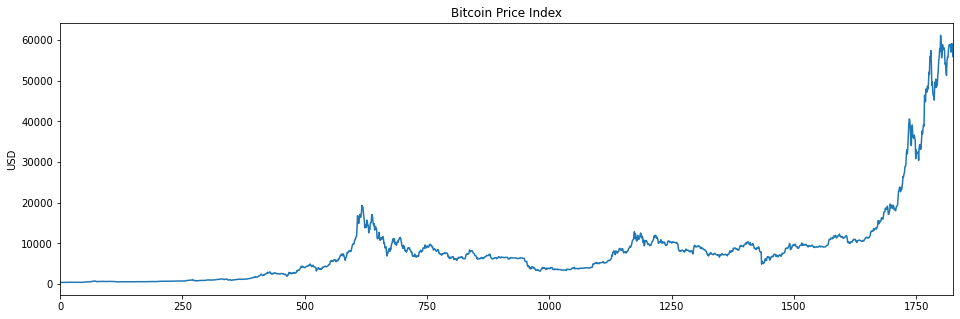

In [36]:
title='Bitcoin Price Index'
ylabel='USD'
xlabel='' # we don't really need a label here

ax = df1['bpi'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Look at epi
Rather than prepare a separate plot, we can use matplotlib to plot epi behind our bpi data.

In [37]:
#hol_df['holiday'] = 1

In [38]:
#df2 = pd.merge(df1, hol_df, how="left", on="date")

In [39]:
#df2.head(20)

In [40]:
#grouped_hol = df2.groupby('date').holiday.sum()
#grouped_hol.head(20)

In [41]:
#df3 = grouped_hol.to_frame()
df3 = df1

In [42]:
df1['epi'] = df1['epi'].astype(float)
#df1['ETH Mkt Cap'] = df1['ETH Mkt Cap'].astype(float)
#df1['ETH Total Vol'] = df1['ETH Total Vol'].astype(float)

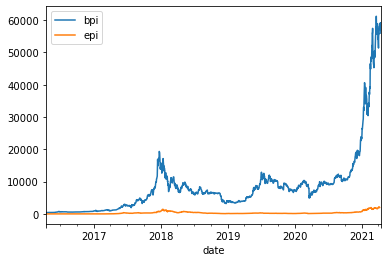

In [43]:
title='Ethereum Price Index'
ylabel='USD'
xlabel='' # we don't really need a label here

lines = df1.plot.line(x='date', y=['bpi','epi'])
#plt.plot( 'date', 'epi', data=df1, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
#plt.plot( 'date', 'ETH Total Vol', data=df1, marker='', color='olive', linewidth=2)
# show legend
plt.legend()

# show graph
plt.show()
#for x in df3.query('holiday>=1').index:       # for days where holiday == 1
#    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

## Test for stationarity

In [44]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [45]:
adf_test(df1['epi'])

Augmented Dickey-Fuller Test: 
ADF test statistic         0.852466
p-value                    0.992438
# lags used               23.000000
# observations          1795.000000
critical value (1%)       -3.433998
critical value (5%)       -2.863152
critical value (10%)      -2.567628
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [46]:
df1['diff_bpi'] = np.append(np.nan, np.diff(df1['bpi']))
df1['diff_epi'] = np.append(np.nan, np.diff(df1['epi']))
df1

,date,bpi,epi,diff_bpi,diff_epi
0,2016-04-15,418.0890,8.555982,NaN,NaN
1,2016-04-16,418.4190,9.323170,0.3300,0.767188
2,2016-04-17,421.1110,8.960482,2.6920,-0.362688
3,2016-04-18,422.9900,8.696773,1.8790,-0.263709
4,2016-04-19,425.9900,8.484151,3.0000,-0.212622
5,2016-04-20,424.4010,8.111041,-1.5890,-0.373110
6,2016-04-21,425.1060,7.855107,0.7050,-0.255934
7,2016-04-22,429.9800,8.377193,4.8740,0.522086
8,2016-04-23,430.8370,7.995361,0.8570,-0.381831
9,2016-04-24,427.8620,7.812752,-2.9750,-0.182610


In [47]:
adf_test(df1['diff_epi'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.981052e+00
p-value                 8.190405e-10
# lags used             2.500000e+01
# observations          1.792000e+03
critical value (1%)    -3.434004e+00
critical value (5%)    -2.863154e+00
critical value (10%)   -2.567629e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


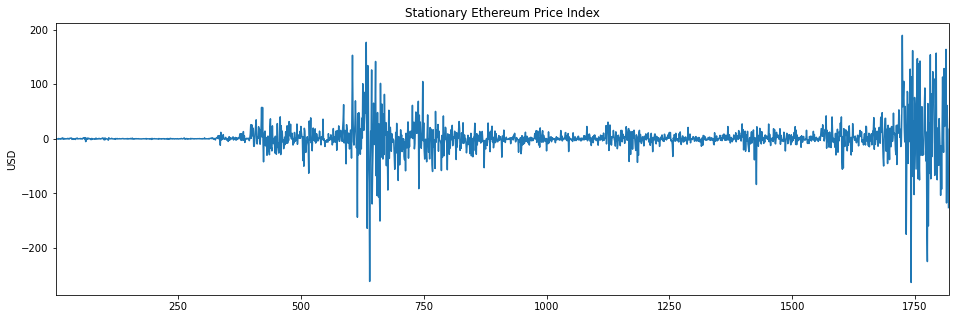

In [48]:
title='Stationary Ethereum Price Index'
ylabel='USD'
xlabel='' # we don't really need a label here

ax = df1['diff_epi'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [49]:
df2 = df1.dropna(subset=['epi'])
df2

,date,bpi,epi,diff_bpi,diff_epi
0,2016-04-15,418.0890,8.555982,NaN,NaN
1,2016-04-16,418.4190,9.323170,0.3300,0.767188
2,2016-04-17,421.1110,8.960482,2.6920,-0.362688
3,2016-04-18,422.9900,8.696773,1.8790,-0.263709
4,2016-04-19,425.9900,8.484151,3.0000,-0.212622
5,2016-04-20,424.4010,8.111041,-1.5890,-0.373110
6,2016-04-21,425.1060,7.855107,0.7050,-0.255934
7,2016-04-22,429.9800,8.377193,4.8740,0.522086
8,2016-04-23,430.8370,7.995361,0.8570,-0.381831
9,2016-04-24,427.8620,7.812752,-2.9750,-0.182610


In [50]:
len(df2)

1819

## Our data is stationary, on to modeling!

In [51]:
len(df1)

1826

In [52]:
df1.set_index('date', inplace=True)
df1.head()

,bpi,epi,diff_bpi,diff_epi
date,,,,
2016-04-15,418.089,8.555982,NaN,NaN
2016-04-16,418.419,9.323170,0.330,0.767188
2016-04-17,421.111,8.960482,2.692,-0.362688
2016-04-18,422.990,8.696773,1.879,-0.263709
2016-04-19,425.990,8.484151,3.000,-0.212622


In [53]:
# Set four months for testing
train = df1.iloc[:1705]
test = df1.iloc[1705:]

### Fit a SARIMA(5,1,3)(1, 0, [1, 2], 12) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

In [54]:
auto_arima(df2['epi'],exogenous=df2[['bpi']],seasonal=True,m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1819
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood               -8639.136
Date:                            Thu, 08 Apr 2021   AIC                          17294.273
Time:                                    09:03:18   BIC                          17338.317
Sample:                                         0   HQIC                         17310.523
                                           - 1819                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7600      1.162      1.515      0.130      -0.517       4.037
bpi           -0.0004      0.000     -1.003      0.316      -0.001       0.000
ar.L1          0.2090      0.010     20.863      0.000       0.189       0.229
ar.L2         -0.8242      0.013    -61.612      0.000      -0.850      -0.798
ma.L1         -0.1843      0.007    -24.609      0.000      -0.199      -0.170
ma.L2          0.9426      0.009    110.863      0.000       0.926       0.959
ar.S.L4        0.0536      0.012      4.623      0.000       0.031       0.076
sigma2       772.7766      8.066     95.805      0.000     756.967     788.586
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):             31364.61
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               8.34   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
model = SARIMAX(df1['epi'],exog=df1['bpi'],order=(2,1,3),seasonal_order=(2, 0, [1, 2], 4),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    epi   No. Observations:                 1826
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 4)   Log Likelihood               -8627.446
Date:                                Thu, 08 Apr 2021   AIC                          17276.892
Time:                                        09:03:28   BIC                          17337.494
Sample:                                    04-15-2016   HQIC                         17299.247
                                         - 04-14-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
bpi           -0.0006      0.000     -1.211      0.226      -0.002       0.000
ar.L1          0.2270      0.014     16.763      0.000       0.200       0.253
ar.L2         -0.8440      0.014    -60.124      0.000      -0.872      -0.816
ma.L1         -0.2523      0.020    -12.847      0.000      -0.291      -0.214
ma.L2          0.9593      0.009    107.814      0.000       0.942       0.977
ma.L3         -0.0580      0.013     -4.376      0.000      -0.084      -0.032
ar.S.L4        0.0704      0.056      1.262      0.207      -0.039       0.180
ar.S.L8       -0.7776      0.043    -18.168      0.000      -0.861      -0.694
ma.S.L4        0.0034      0.060      0.056      0.955      -0.114       0.121
ma.S.L8        0.7359      0.047     15.735      0.000       0.644       0.828
sigma2       807.2921      9.031     89.393      0.000     789.592     824.992
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             33894.53
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               7.85   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
# Obtain predicted values
start=len(train)+len(test)-21
end=len(train)+len(test)-1
exog_forecast = test['bpi']  # requires two brackets to yield a df, because statsmodel need data frame
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(2,1,3)(2, 0, [1, 2], 4) Predictions')
#predictions = ((predictions*predictions*predictions*predictions) ** (1./3))/2.3
#len(df1)+5 - len(df1)-25

In [57]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['bpi']]  # requires two brackets to yield a shape of (121,1), because statsmodel need data frame
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(4,1,5)(0, 0, [1, 2], 12) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'USD')]

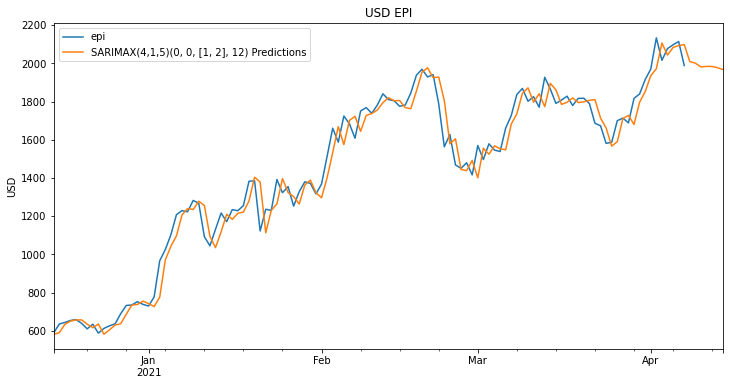

In [58]:
# Plot predictions against known values
title='USD EPI'
ylabel='USD'
xlabel=''

ax = test['epi'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#for x in test.query('holiday>=1').index: 
#    ax.axvline(x=x, color='k', alpha = 0.3);

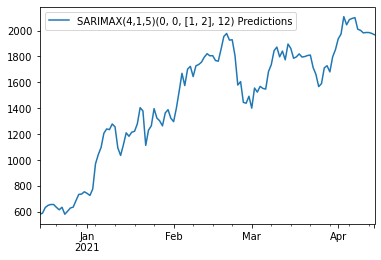

In [59]:
title='Ethereum Price Index'
ylabel='USD'
xlabel='' # we don't really need a label here

lines = predictions.plot(x='date', y=['epi'])
#plt.plot( 'date', 'epi', data=df1, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
#plt.plot( 'date', 'ETH Total Vol', data=df1, marker='', color='olive', linewidth=2)
# show legend
plt.legend()

# show graph
plt.show()

In [60]:
predictions

2020-12-15     581.623748
2020-12-16     590.321034
2020-12-17     634.069063
2020-12-18     650.996466
2020-12-19     657.454039
2020-12-20     657.298642
2020-12-21     635.363211
2020-12-22     616.515321
2020-12-23     635.880997
2020-12-24     582.368414
2020-12-25     605.514450
2020-12-26     630.378182
2020-12-27     637.169133
2020-12-28     686.922798
2020-12-29     735.371192
2020-12-30     737.894361
2020-12-31     755.550503
2021-01-01     743.267761
2021-01-02     727.212852
2021-01-03     776.602934
2021-01-04     971.302464
2021-01-05    1042.588388
2021-01-06    1097.678419
2021-01-07    1207.203697
2021-01-08    1240.488015
2021-01-09    1235.489061
2021-01-10    1278.780738
2021-01-11    1256.307675
2021-01-12    1094.485842
2021-01-13    1036.016283
2021-01-14    1118.283024
2021-01-15    1210.261368
2021-01-16    1183.918231
2021-01-17    1215.487534
2021-01-18    1222.245871
2021-01-19    1280.518957
2021-01-20    1404.664840
2021-01-21    1379.418943
2021-01-22  